This notebook explores whether there's a signal for DNA extraction

In [126]:
import os
import sys
import pandas as pd
import numpy as np
import yaml

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

from IPython.display import display


from sklearn.decomposition import PCA
from sklearn import manifold

# Add util to the path
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.insert(0, src_dir)
import FileIO as fio
from util import collapse_taxonomic_contents_df, compare_otus_teststat

## Read all data and combine into one df

Will also save this file to this folder, so I don't have to re-do it every time.

In [127]:
# Read in dfdict
datadir = '../../data/clean_tables'
dfdict = fio.read_dfdict_data(datadir)

Reading datasets...
cdi_youngster hiv_noguerajulian hiv_lozupone t1d_alkanani edd_singh asd_son crc_zeller ra_scher ibd_papa ob_zhu crc_baxter cdi_schubert par_scheperjans crc_wang ibd_gevers nash_zhu cdi_vincent ob_ross asd_kang mhe_zhang crc_chen ob_turnbaugh hiv_dinh crc_zackular ibd_morgan ob_zupancic ob_goodrich t1d_mejialeon ibd_willing nash_wong 
Reading datasets... Finished.


In [128]:
# Collapse to genus level
for dataset in dfdict:
    # Collapse to genus level and relabel samples with dataset ID
    df = dfdict[dataset]['df']
    df = collapse_taxonomic_contents_df(df, 'genus')
    df.index = [dataset + '-' + i for i in df.index]
    dfdict[dataset]['df'] = df
    
    # Also relabel indices in metadata
    meta = dfdict[dataset]['meta']
    meta.index = [dataset + '-' + i for i in meta.index]
    dfdict[dataset]['meta'] = meta

In [129]:
# Concatenate and save data and corresponding metadata
# ob_zhu and nash_zhu are duplicates, consider only once
# cdi_youngster and t1d_mejialeon have fewer than 10 healthy controls
ignore_datasets = ['ob_zhu', 'cdi_youngster', 't1d_mejialeon']

bigdf = pd.concat([dfdict[d]['df'] for d in dfdict if d not in ignore_datasets])
bigmeta = pd.concat([dfdict[d]['meta'] for d in dfdict if d not in ignore_datasets])
print(bigdf.shape)

(4548, 302)


In [130]:
## Read yaml to get the DNA extraction info
fn_yaml = '../../data/user_input/results_folders.yaml'
y = yaml.load(open(fn_yaml, 'r'))
bigmeta['dna_extraction'] = bigmeta['dataset'].map(lambda x: y[x]['dna_extraction'])

In [131]:
healthy_df = bigdf.loc[bigmeta.query('DiseaseState == "H"').index]
# Remove genera which are all NaN or 0
healthy_df = healthy_df.dropna(how='all', axis=1).fillna(0.0)
healthy_df = healthy_df.loc[:, healthy_df.sum(axis=0) > 0]


In [132]:
pca_abun = PCA().fit(healthy_df.values)
pca_abun_vals = pca_abun.transform(healthy_df.values)
pca_abun_df = pd.DataFrame({'PC1': pca_abun_vals[:, 0], 
                            'PC2': pca_abun_vals[:, 1], 
                            'dna_extraction': bigmeta.loc[healthy_df.index, 'dna_extraction']})


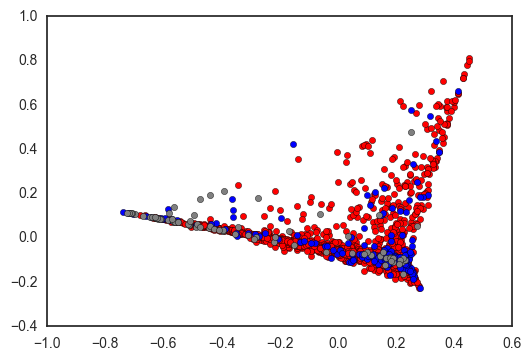

In [133]:
paldict = {'bead_beating': 'red', 'lysis_buffer': 'blue', 'unknown': 'gray', 'unsure': 'gray'}

fig, ax = plt.subplots()
for g, subdf in pca_abun_df.groupby('dna_extraction'):
    ax.scatter(subdf['PC1'], subdf['PC2'], c=paldict[g])


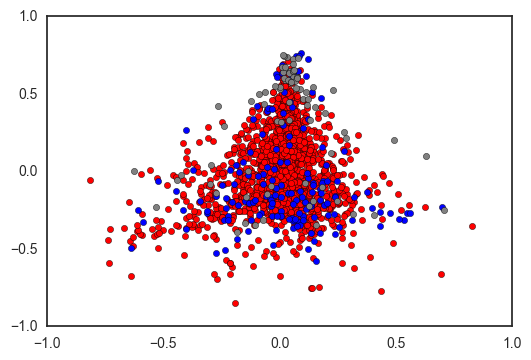

In [134]:
n_components = 2

mds_abun = manifold.MDS(n_components, max_iter=100, n_init=1).fit_transform(healthy_df.values)
mds_abun_df = pd.DataFrame({'PC1': mds_abun[:, 0], 
                            'PC2': mds_abun[:, 1], 
                            'dna_extraction': bigmeta.loc[healthy_df.index, 'dna_extraction']})
fig, ax = plt.subplots()
for g, subdf in mds_abun_df.groupby('dna_extraction'):
    ax.scatter(subdf['PC1'], subdf['PC2'], c=paldict[g])


## Univariate tests for DNA extraction

In [79]:
bead_smpls = bigmeta.query('dna_extraction == "bead_beating"').index
lysis_smpls = bigmeta.query('dna_extraction == "lysis_buffer"').index

results = compare_otus_teststat(healthy_df, bead_smpls, lysis_smpls)

In [33]:
results.query('p < 0.05').shape

(152, 2)

In [34]:
bigdf.shape

(4548, 302)

In [37]:
results.sort_values(by='p').head()

,test-stat,p
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus,691.912,1.71616e-152
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas,628.693,9.61769e-139
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Asticcacaulis,614.871,9.75637e-136
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Geodermatophilaceae;g__Geodermatophilus,463.16,9.87013e-103
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Caulobacter,425.719,1.38852e-94


In [48]:
tidy = pd.melt(healthy_df.reset_index(), id_vars='index', var_name='otu', value_name='abun')
tidy = pd.merge(tidy, bigmeta.reset_index()[['index', 'dna_extraction', 'dataset']])
tidy['log_abun'] = np.log10(tidy['abun'] + 1e-6)
tidy.head()

,index,otu,abun,dna_extraction,dataset,log_abun
0,mhe_zhang-H001,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,0.0,bead_beating,mhe_zhang,-6.0
1,mhe_zhang-H001,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,0.0,bead_beating,mhe_zhang,-6.0
2,mhe_zhang-H001,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,0.0,bead_beating,mhe_zhang,-6.0
3,mhe_zhang-H001,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;...,0.0,bead_beating,mhe_zhang,-6.0
4,mhe_zhang-H001,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.0,bead_beating,mhe_zhang,-6.0


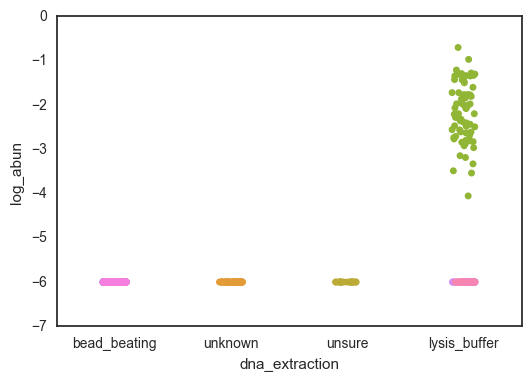

In [50]:
o = 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus'
sns.stripplot(data=tidy.query('otu == @o'), x='dna_extraction', y='log_abun', 
              hue='dataset', split=False, jitter=True)
plt.legend('')

Hm okay, so this OTU is just present in one dataset... Need to filter these out!

In [90]:
# This counts the number of datasets each OTU is non-zero in
nonzero = (tidy.groupby(['otu', 'dataset']).sum()['abun'] > 0).reset_index().groupby('otu').sum()['abun'].reset_index()
nonzero_otus = nonzero.query('abun > 5')['otu'].values.tolist()

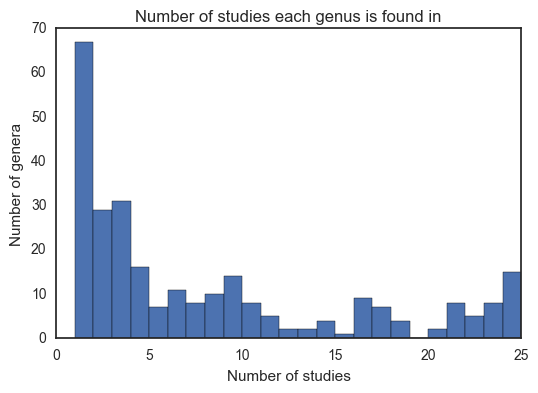

In [91]:
plt.hist(nonzero['abun'], bins=range(26))
plt.xlabel('Number of studies')
plt.ylabel('Number of genera')
plt.title('Number of studies each genus is found in')

In [92]:
nonzero_results = results.reset_index().query('index == @nonzero_otus')
nonzero_results.sort_values(by='p').head()

,index,test-stat,p
91,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,189.745,3.61453e-43
93,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,166.137,5.16322e-38
139,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,161.323,5.81673e-37
79,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,140.459,2.11287e-32
69,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,126.43,2.47582e-29


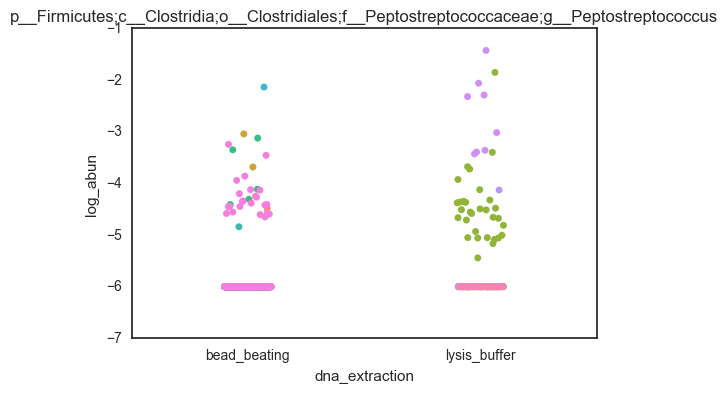

In [98]:
o = nonzero_results.sort_values(by='p').iloc[2]['index']
sns.stripplot(data=tidy.query('otu == @o'), x='dna_extraction', y='log_abun', 
              hue='dataset', split=False, jitter=True, order=['bead_beating', 'lysis_buffer'])
plt.title(';'.join(o.split(';')[1:]))
plt.legend('')

## Wait - should do chi square

These results are super batchy and don't seem super meaningful.

Bead-beating vs. lysis, present in study vs. not present in study?

In [125]:
presence = (tidy.groupby(['otu', 'dataset']).sum()['abun'] > 0).reset_index()
presence = pd.merge(presence, bigmeta[['dataset', 'dna_extraction']])
presence['present'] = presence['abun'].astype(int)
presence = presence.drop_duplicates()
presence.head()

,otu,dataset,abun,dna_extraction,present
0,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,asd_kang,False,lysis_buffer,0
39,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,asd_kang,False,lysis_buffer,0
78,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,asd_kang,False,lysis_buffer,0
117,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;...,asd_kang,False,lysis_buffer,0
156,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,asd_kang,False,lysis_buffer,0


In [111]:
tmp = presence.query('otu == @o').query('dna_extraction == "bead_beating" | dna_extraction == "lysis_buffer"')
pd.crosstab(tmp['dna_extraction'], tmp['present'])

present,0,1
dna_extraction,,
bead_beating,12,6
lysis_buffer,2,3


In [112]:
from scipy.stats import fisher_exact
fisher_exact(pd.crosstab(tmp['dna_extraction'], tmp['present']))

(3.0, 0.34283336800499364)

In [117]:
chisquare = []
for o, subdf in presence.query('dna_extraction == "bead_beating" | dna_extraction == "lysis_buffer"').groupby('otu'):
    if len(subdf['present'].unique()) > 1:
        tmp = fisher_exact(pd.crosstab(subdf['dna_extraction'], subdf['present']))
        chisquare.append([o, tmp[0], tmp[1]])

In [121]:
df_chisquare = pd.DataFrame(chisquare, columns=['otu', 'odds_ratio', 'pval'])
df_chisquare.sort_values(by='pval').head()

,otu,odds_ratio,pval
104,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,25.500000,0.020892
113,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,0.039526
67,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,inf,0.039526
157,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;...,0.083333,0.048174
40,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.096154,0.056168


In [124]:
for o in df_chisquare.query('pval < 0.05')['otu']:
    print(o)
    subdf = presence.query('otu == @o').query('dna_extraction == "bead_beating" | dna_extraction == "lysis_buffer"')
    display(pd.crosstab(subdf['dna_extraction'], subdf['present']))

k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Facklamia


present,0,1
dna_extraction,,
bead_beating,18,0
lysis_buffer,3,2


k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Incertae_Sedis_XI;g__Murdochiella


present,0,1
dna_extraction,,
bead_beating,17,1
lysis_buffer,2,3


k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea


present,0,1
dna_extraction,,
bead_beating,0,18
lysis_buffer,2,3


k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Catenibacterium


present,0,1
dna_extraction,,
bead_beating,2,16
lysis_buffer,3,2


That's surprising... there are only five genera which are significantly differently present between the extraction methods.
